In [1]:
%%capture
import logging
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["numexpr", "numba", "bokeh", "matplotlib", "tornado", "Comm"],
)

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from bokeh.io import output_notebook
from polars import col

from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.utils import to_describe
from src.plots.plot_stimulus import plot_stimulus_with_shapes

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
def load_configuration(file_path: str) -> dict:
    """Load configuration from a TOML file."""
    file_path = Path(file_path)
    with open(file_path, "rb") as file:
        return tomllib.load(file)


config = load_configuration("src/experiments/measurement/measurement_config.toml")[
    "stimulus"
]


In [4]:
config = {
    "seeds": config["seeds"],
    "sample_rate": config["sample_rate"],
    "half_cycle_num": config["half_cycle_num"],
    "period_range": config["period_range"],
    "amplitude_range": config["amplitude_range"],
    "inflection_point_range": config["inflection_point_range"],
    "shorten_expected_duration": config["shorten_expected_duration"],
    "major_decreasing_half_cycle_num": config["major_decreasing_half_cycle_num"],
    "major_decreasing_half_cycle_period": config["major_decreasing_half_cycle_period"],
    "major_decreasing_half_cycle_amplitude": config[
        "major_decreasing_half_cycle_amplitude"
    ],
    "major_decreasing_half_cycle_min_y_intercept": config[
        "major_decreasing_half_cycle_min_y_intercept"
    ],
    "plateau_num": config["plateau_num"],
    "plateau_duration": config["plateau_duration"],
    "plateau_percentile_range": config["plateau_percentile_range"],
    "prolonged_minima_num": config["prolonged_minima_num"],
    "prolonged_minima_duration": config["prolonged_minima_duration"],
}
assert len(config["seeds"]) == len(set(config["seeds"])), "Seeds must be unique"
assert len(config["seeds"]) == 12, "There must be 12 seeds"

dummy_participant = {
    "temperature_baseline": 47.0,
    "temperature_range": 1.5,  # VAS 0 - VAS 70
}


dummy_config = {
    "seeds": [1, 2, 3],
    "half_cycle_num": 2,
    "period_range": [2, 2],
    "major_decreasing_half_cycle_num": 0,
    "shorten_expected_duration": 0,
    "amplitude_range": [0.9, 1.0],
    "plateau_num": 0,
    "prolonged_minima_num": 0,
}

# Plot one random seed
config.update(dummy_participant)
seed = np.random.randint(0, 1000)
stimulus = StimulusGenerator(config, debug=0, seed=3396)

# print("Plot one random seed:")
plot_stimulus_with_shapes(stimulus)

In [5]:
stimulus._extensions, stimulus.plateau_intervals_idx

([(np.int64(55), 150), (np.int64(812), 150), (np.int64(1250), 50)],
 [(np.int64(55), np.int64(205)), (np.int64(812), np.int64(962))])

In [9]:
stimulus.labels["major_decreasing_intervals"]

[(29000, 49000), (105000, 125000), (160000, 180000)]

In [6]:
print("Major decreasing intervals:", stimulus.major_decreasing_intervals_idx)
print("Decreasing intervals:", stimulus.decreasing_intervals_idx)
print("Increasing intervals:", stimulus.increasing_intervals_idx)
stimulus.periods, np.sign(stimulus.amplitudes)

Major decreasing intervals: [(np.int64(290), np.int64(490)), (np.int64(1050), np.int64(1250)), (np.int64(1600), np.int64(1800))]
Decreasing intervals: [(290, 490), (660, 760), (1050, 1250), (1380, 1450), (1600, 1800)]
Increasing intervals: [(0, 290), (490, 660), (760, 1050), (1300, 1380), (1450, 1600)]


(array([14, 20, 17, 10, 14, 20,  8,  7, 15, 20]),
 array([-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.]))

In [7]:
print("Major decreasing intervals:", stimulus.major_decreasing_intervals_idx)
print("Major decreasing intervals:", stimulus.major_decreasing_intervals_ms)
print("Decreasing intervals:", stimulus.decreasing_intervals_idx)
print("Increasing intervals:", stimulus.increasing_intervals_idx)
stimulus.periods, np.sign(stimulus.amplitudes)

Major decreasing intervals: [(np.int64(290), np.int64(490)), (np.int64(1050), np.int64(1250)), (np.int64(1600), np.int64(1800))]


AttributeError: 'StimulusGenerator' object has no attribute 'major_decreasing_intervals_ms'

In [8]:
stimulus.major_decreasing_half_cycle_idx[:]

array([1, 5, 9])

In [9]:
stimulus._extensions, stimulus.major_decreasing_half_cycle_idx

([(np.int64(55), 150), (np.int64(812), 150), (np.int64(1250), 50)],
 array([1, 5, 9]))

## Show all stimuli

We want 12 seeds for unpredictable stimuli (note peak-and-end-rule)
- some with plateau in last peak
- some with low end temperature
- no mere sinosiodal patterns

In [9]:
from pprint import pprint

stimuli = pl.DataFrame()
interval_dict = dict()
# config.pop("temperature_baseline")
# config.pop("temperature_range")
for seed in config["seeds"]:
    stimulus = StimulusGenerator(config, seed)
    df = pl.DataFrame(
        {
            "y": stimulus.y,
            "time": np.arange(len(stimulus.y)),
            "seed": np.array([seed] * len(stimulus.y)),
        }
    )
    interval_dict[seed] = stimulus.major_decreasing_intervals_ms
    stimuli = pl.concat([stimuli, df])

pprint(interval_dict)
output_notebook()  # annoyingly, this needs to be called again or the plot will not show
stimuli.hvplot(
    x="time",
    y="y",
    kind="line",
    groupby="seed",
    ylim=config["temperature_baseline"]
    + np.array([-1, 1]) * config["temperature_range"] / 2,
)

AttributeError: 'StimulusGenerator' object has no attribute 'major_decreasing_intervals_ms'

In [8]:
out = stimuli.group_by("seed", maintain_order=True).agg(to_describe("y"))
out

NameError: name 'stimuli' is not defined

NameError: name 'stimuli' is not defined

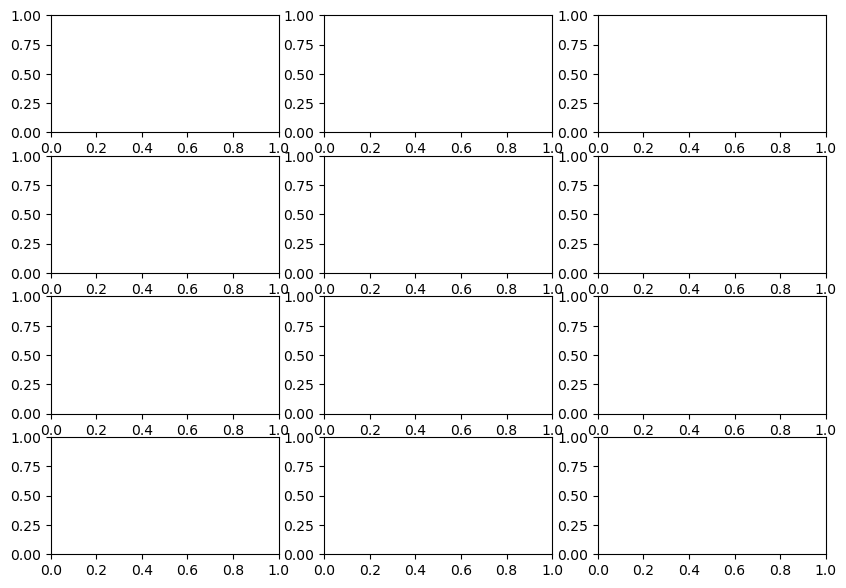

In [7]:
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
axes = axes.flatten()

grouped = stimuli.group_by("seed", maintain_order=True).agg(col("time"), col("y"))
for i, row in enumerate(grouped.to_dicts()):
    ax = axes[i]
    ax.plot(row["time"], row["y"])
    ax.set_title(f"Seed: {row['seed']}")
    ax.axis(False)


plt.tight_layout()
plt.show()

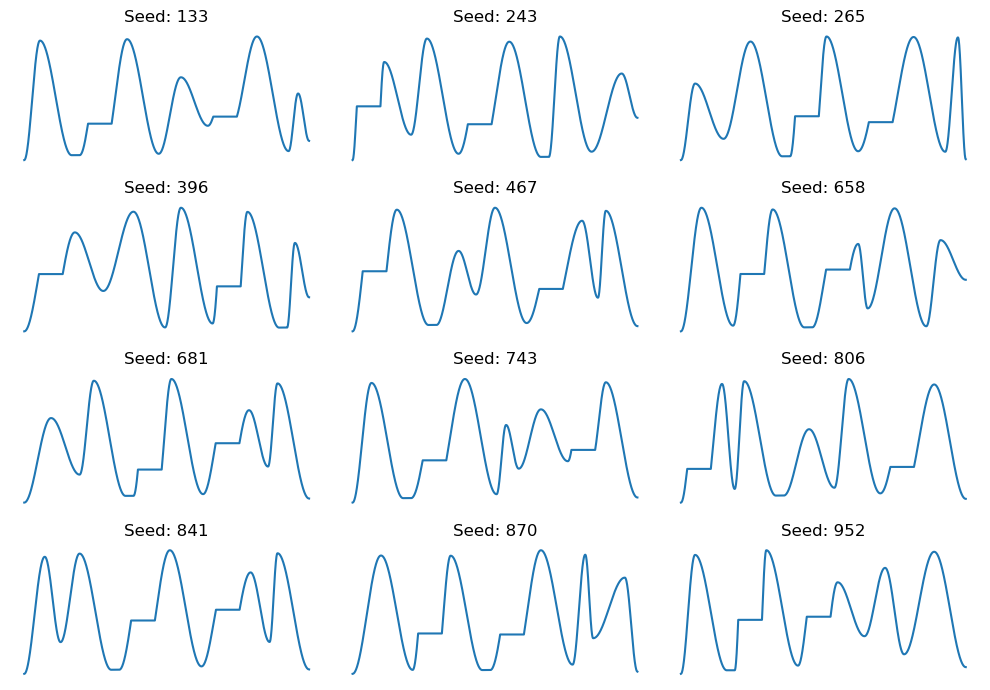

In [15]:
import bokeh
import numpy as np

from src.experiments.measurement.stimulus_generator import StimulusGenerator


def plot_stimulus_with_shapes(stimulus: StimulusGenerator):
    """
    Plot the stimulus data with shapes for the major decreasing intervals using Bokeh.
    """
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate

    # Create a new plot
    p = figure(
        title=f"Seed: {stimulus.seed}",
        x_axis_label="Time (s)",
        y_axis_label="Temperature (°C)",
        width=900,
        height=300,
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )

    # Plot the main line
    p.line(time, stimulus.y, line_color="navy", line_width=2)

    # Add shapes for the major decreasing intervals
    for interval in stimulus.major_decreasing_intervals_idx:
        start_time, end_time = (
            interval[0] / stimulus.sample_rate,
            interval[1] / stimulus.sample_rate,
        )
        p.add_layout(
            bokeh.models.BoxAnnotation(
                left=start_time,
                right=end_time,
                fill_color="salmon",
                fill_alpha=0.125,
            )
        )

    # Show the plot
    show(p)


plot_stimulus_with_shapes(stimulus)

NameError: name 'figure' is not defined

In [16]:
import altair as alt
import numpy as np

from src.experiments.measurement.stimulus_generator import StimulusGenerator


def plot_stimulus_with_shapes(stimulus: StimulusGenerator):
    """
    Plot the stimulus data with shapes for the major decreasing intervals using Altair.
    """
    # Prepare the data
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate
    df = pl.DataFrame({"time": time, "temperature": stimulus.y})

    # Create the main line chart
    line = (
        alt.Chart(df)
        .mark_line()
        .encode(
            x=alt.X("time", title="Time (s)"),
            y=alt.Y("temperature", title="Temperature (°C)"),
        )
    )

    # Create rectangles for major decreasing intervals
    rects = []
    for interval in stimulus.major_decreasing_intervals_idx:
        start_time, end_time = (
            interval[0] / stimulus.sample_rate,
            interval[1] / stimulus.sample_rate,
        )
        rect_df = pd.DataFrame({"x": [start_time], "x2": [end_time]})
        rect = (
            alt.Chart(rect_df)
            .mark_rect(opacity=0.125, color="salmon")
            .encode(
                x="x",
                x2="x2",
                y=alt.value(0),  # Bottom of chart
                y2=alt.value(300),  # Top of chart (adjust as needed)
            )
        )
        rects.append(rect)

    # Combine all layers
    chart = (
        alt.layer(line, *rects)
        .properties(width=900, height=300, title=f"Seed: {stimulus.seed}")
        .configure_axis(labelFontSize=12, titleFontSize=14, titleFontWeight="bold")
        .configure_title(fontSize=16, fontWeight="bold")
    )

    # Customize x-axis ticks
    chart = chart.configure_axisX(
        tickCount=len(time) // 10  # Adjust this value to change tick density
    )

    return chart


# TODO: add main function for figure generation for paper, etc.

# To display the chart:
chart = plot_stimulus_with_shapes(stimulus)
chart.display()


NameError: name 'pd' is not defined

In [38]:
import numpy as np
import pandas as pd

from src.experiments.measurement.stimulus_generator import StimulusGenerator


def plot_stimulus_with_shapes(stimulus: StimulusGenerator):
    """
    Plot the stimulus data with shapes for the major decreasing intervals using Altair.
    """
    # Prepare the data
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate
    df = pd.DataFrame({"time": time, "temperature": stimulus.y})

    # Calculate y-axis domain
    y_min, y_max = min(stimulus.y), max(stimulus.y)
    y_padding = (y_max - y_min) * 0.05  # 5% padding

    # Create the main line chart
    line = (
        alt.Chart(df)
        .mark_line()
        .encode(
            x=alt.X("time", title="Time (s)"),
            y=alt.Y(
                "temperature",
                title="Temperature (°C)",
                scale=alt.Scale(domain=[y_min - y_padding, y_max + y_padding]),
            ),
        )
    )

    # Create rectangles for major decreasing intervals
    rects = []
    for interval in stimulus.major_decreasing_intervals_idx:
        start_time, end_time = (
            interval[0] / stimulus.sample_rate,
            interval[1] / stimulus.sample_rate,
        )
        rect_df = pd.DataFrame({"x": [start_time], "x2": [end_time]})
        rect = (
            alt.Chart(rect_df)
            .mark_rect(opacity=0.125, color="salmon")
            .encode(
                x="x",
                x2="x2",
                y=alt.value(0),  # Bottom of chart
                y2=alt.value(300),  # Top of chart (adjust as needed)
            )
        )
        rects.append(rect)

    # Combine all layers
    chart = (
        alt.layer(line, *rects)
        .properties(width=900, height=300, title=f"Seed: {stimulus.seed}")
        .configure_axis(labelFontSize=12, titleFontSize=14, titleFontWeight="bold")
        .configure_title(fontSize=16, fontWeight="bold")
    )

    # Customize x-axis ticks
    chart = chart.configure_axisX(
        tickCount=len(time) // 10  # Adjust this value to change tick density
    )

    return chart


# TODO: add main function for figure generation for paper, etc.

# To display the chart:
chart = plot_stimulus_with_shapes(stimulus)
chart.display()


alt.LayerChart(...)

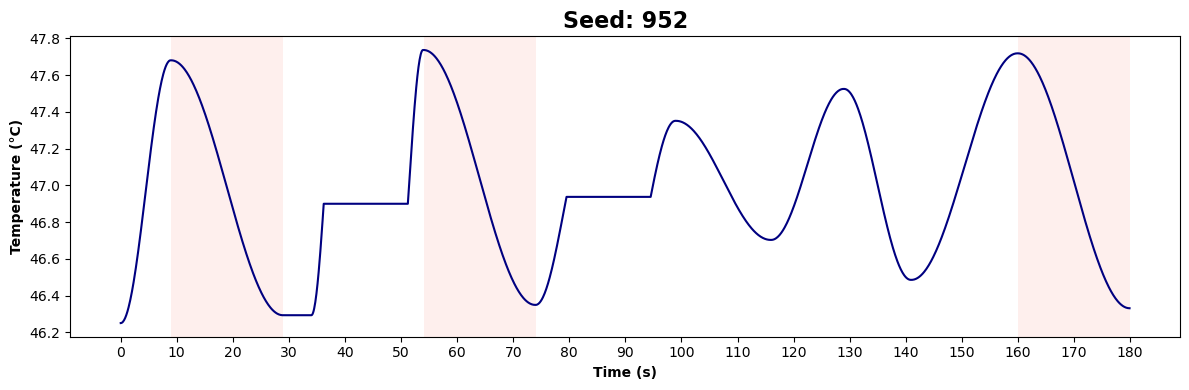

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

from src.experiments.measurement.stimulus_generator import StimulusGenerator


def plot_stimulus_with_shapes(stimulus: StimulusGenerator, save_path=None):
    """
    Plot the stimulus data with shapes for the major decreasing intervals using Matplotlib.
    """
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate

    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot the main line
    ax.plot(time, stimulus.y, color="navy", linewidth=1.5)

    # Add shapes for the major decreasing intervals
    for interval in stimulus.major_decreasing_intervals_idx:
        start_time, end_time = (
            interval[0] / stimulus.sample_rate,
            interval[1] / stimulus.sample_rate,
        )
        rect = Rectangle(
            (start_time, ax.get_ylim()[0]),
            end_time - start_time,
            ax.get_ylim()[1] - ax.get_ylim()[0],
            facecolor="salmon",
            alpha=0.125,
        )
        ax.add_patch(rect)

    # Customize the plot
    ax.set_xlabel("Time (s)", fontweight="bold")
    ax.set_ylabel("Temperature (°C)", fontweight="bold")
    ax.set_title(f"Seed: {stimulus.seed}", fontsize=16, fontweight="bold")
    ax.set_xticks(np.arange(0, max(time) + 1, 10))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()


# TODO: add main function for figure generation for paper, etc.

plot_stimulus_with_shapes(stimulus)